# 必要なPythonライブラリのインポート
分類問題を解くために、ロジスティック回帰モデルを使用する。

モデルを評価するために以下の指標を使用する。
* accuracy
* precision
* recall
* f1 score

混合行列を表示するためのライブラリもインポートしておく。

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# データの読み込み
Kaggleの[Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects) から ``ks-projects-201801.csv`` をダウンロードする。

ダウンロードしたcsvファイルを読み込む。

In [57]:
df_kick = pd.read_csv('./data/ks-projects-201801.csv')
display(df_kick.head())
df_kick.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


# 読み込んだデータの各カラムの取り扱い方針

* ID  
  レコードを識別するためのIDであり、説明変数にはならない。
* name  
  Project名  
  質的変数であり、文字列のままでは分類できない。  
  37万件以上の名前から規則性を見出すのは困難なので、説明変数にはできない。
* category  
  Projectのカテゴリ  
  Projectの種類が成否に影響する可能性はある。  
  カテゴリ分けしてダミー変数に変換しないと、説明変数にはできない。
* main_category  
  Projectのカテゴリをより大きなグループで集約したもの。  
  説明変数にするには、categoryと同様、ダミー変数への変換が必要。  
  1日目の時点では、説明変数にはしない。
* currency  
  通貨  
  ``USD`` が ``73%`` 以上を占める。  
  通貨の信用度が資金集めに影響する可能性は否定できないが、大きな影響は考えにくい。  
  1日目の時点では、説明変数にはしない。
* goal  
  目標金額
  金額の大小が成否を決めると想定されるため、説明変数の候補である。
  しかし、通貨が異なるレコードがあるため、通貨を統一しないと正しい比較ができない。  
  このままでは説明変数としては使えない。
* deadline  
  募集期限日  
  この項目単独ではなく、募集開始日と合わせて募集期間を説明変数にするのがよさそう。  
  募集期間の長さが成否に影響すると想定されるためである。
* launched  
  募集開始日  
  募集期限日と合わせて、募集期間に変換して説明変数とする。
* pledged  
  実際の募金額  
  通貨が異なるレコードがあるため、通貨を統一しないと正しい比較ができない。  
  また、募集が終わらないと実際の募金額がわからないため、事前に成否を予測するモデルの説明変数には使えない。
* state  
  Projectの成否  
  今回の分類の目的変数となる。  
  成功(Successful)とそれ以外とでダミー変数に変換する。
* backers  
  実際に募金した人数  
  募集が終わらないと実際の人数がわからないため、事前に成否を予測するモデルの説明変数には使えない。
* country  
  currencyと同様の扱いとする。
* usd_pledged  
  pledgedをUSDに変換した金額  
  pledgedは説明変数には使えないので、この項目も説明変数にはならない。
* usd_pldeged_real  
  pledgedと同様、この項目も説明変数にはならない。
* usd_goal_real  
  募集金額をUSDに変換したもの。  
  通貨が統一されたので、レコード間の金額の比較が可能となり、説明変数に使える。

# 募集期間(period)のカラムを作成
カラムを作成する前に、deadlineとlaunchedに欠損値がないかを確認する。

In [58]:
df_kick.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

deadlineとlaunchedに欠損値はないことが確認できたので、period列を作成する。

In [59]:
df_kick['deadline_dt'] = pd.to_datetime(df_kick['deadline'])
df_kick['launched_dt'] = pd.to_datetime(df_kick['launched'])
# datetime型同士の差分はtimedeltaオブジェクトになる
# pandas.Series.dt.days属性で募集日数がわかる
df_kick['period_dt'] = df_kick['deadline_dt'] - df_kick['launched_dt']
df_kick['period'] = df_kick['period_dt'].dt.days

display(df_kick.head())
df_kick.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_dt,launched_dt,period_dt,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,2015-10-09,2015-08-11 12:12:28,58 days 11:47:32,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,2017-11-01,2017-09-02 04:43:57,59 days 19:16:03,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,2013-02-26,2013-01-12 00:20:50,44 days 23:39:10,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,2012-04-16,2012-03-17 03:24:11,29 days 20:35:49,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,2015-08-29,2015-07-04 08:35:03,55 days 15:24:57,55


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,period_dt,period
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05,378661,378661.000000
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04,33 days 21:58:10.533968,33.481122
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06,65 days 21:55:09.506515,65.909172
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0 days 00:07:17,0.000000
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03,29 days 02:20:36,29.000000
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03,29 days 16:32:32,29.000000
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04,36 days 15:35:44,36.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,16738 days 23:00:00,16738.000000


# stateの確認
どういう値が入っているのか確認する

In [60]:
df_kick['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

明確に成否がわかるのは
* successful
* failed

の2つのみ。

他の値は明確に成否がわからないので、削除する。
* canceled  
  募集がキャンセルされた。そのまま募集が続いてたら成否がどうなっていたかは不明。
* undefined  
  結果が不明
* live  
  募集がまだ続いている。この時点では成否がどうなるかは予測できない。
* suspended  
  募集が中断された。canceledと同様、成否がどうなるかは不明。

# stateの不要な値を削除する
successfulとfailed以外の値を削除した新しいDataFrameを ``df_kick_ed`` とする。

In [61]:
df_kick_ed = df_kick[(df_kick['state'] == 'successful') | (df_kick['state'] == 'failed')]

df_kick_ed['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

# stateの値を数値に変換する
* 0: failed
* 1: successful

In [62]:
df_kick_ed.loc[df_kick_ed['state'] == 'failed', 'state'] = 0
df_kick_ed.loc[df_kick_ed['state'] == 'successful', 'state'] = 1

df_kick_ed['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

# もう一度統計情報を確認する

In [64]:
df_kick_ed.describe()

,ID,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period_dt,period
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05,331675,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,0.403877,116.381581,7.684569e+03,9.943461e+03,4.151000e+04,33 days 09:20:42.280328,32.954902
std,6.191924e+08,1.117917e+06,1.015917e+05,0.490674,965.427268,8.320938e+04,9.673293e+04,1.108930e+06,12 days 17:21:40.477026,12.713329
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0 days 00:07:17,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,0.000000,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,29 days 02:08:03.500000,29.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,0.000000,15.000000,5.020000e+02,7.880000e+02,5.000000e+03,29 days 15:45:44,29.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,1.000000,63.000000,3.421000e+03,4.608000e+03,1.500000e+04,35 days 16:56:35.500000,35.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,1.000000,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,91 days 23:06:13,91.000000


# main_category
main_categoryの値を確認してみる。

どの分野もまんべんなく入っており、説明変数として何を抽出するのか判断が難しい。

In [89]:
df_kick_ed['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

# 欠損値確認
説明変数候補のperiod, usd_goal_realと、目的変数のstateには欠損値がない。

In [90]:
df_kick_ed.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
deadline_dt           0
launched_dt           0
period_dt             0
period                0
dtype: int64

# 外れ値確認
stateから不要なレコードを削除したことで、periodのmaxが91となり、異常に大きい値ではなくなった。  
一方、usd_goal_realのmaxが平均と比べて異常に大きい。

箱ひげ図で確認する。

## usd_goal_real
四分位数から大きく外れている数字が多数ある。  
maxは1.66e+08 USD すなわち、1億6600万ドル(約200億円)となる。

2018年に1.54e+08 USDのクラウドファンディングが成功している。  
これは2018年時点の1位の金額で、2位の2.07e+07 USDと比較して突出して高い。
* [参考](https://relic.co.jp/battery/articles/4530)

1.0e+07 USD以上のデータが多数見受けられ、その大半は失敗していると思われるが、あり得ない金額ではないため、外れ値とはみなさず、そのままとする。

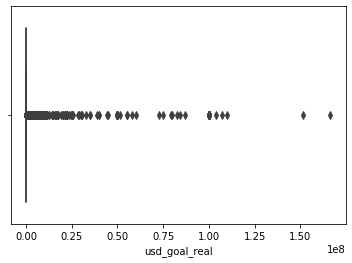

In [68]:
sns.boxplot(df_kick_ed['usd_goal_real'])
plt.show()

In [69]:
df_kick_ed.sort_values('usd_goal_real', ascending = False).head(30)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_dt,launched_dt,period_dt,period
47803,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,GBP,2014-08-08,99000000.0,2014-07-09 00:24:34,0.0,0,0,GB,0.00,0.00,1.663614e+08,2014-08-08,2014-07-09 00:24:34,29 days 23:35:26,29
196531,2000749004,A Celtic Lovestory,Drama,Film & Video,GBP,2015-11-30,100000000.0,2015-11-17 00:47:15,0.0,0,0,GB,0.00,0.00,1.513959e+08,2015-11-30,2015-11-17 00:47:15,12 days 23:12:45,12
367928,944541075,Hydroponic's Skyscraper(un gratte-ciel hydropo...,Technology,Technology,EUR,2015-10-24,100000000.0,2015-08-25 23:52:30,2.0,0,2,FR,2.29,2.20,1.101698e+08,2015-10-24,2015-08-25 23:52:30,59 days 00:07:30,59
222208,2132015082,DER NEANDERTALER (Kinofilm mit Starbesetzung i...,Movie Theaters,Film & Video,EUR,2017-03-14,100000000.0,2017-01-13 20:08:41,36.0,0,2,DE,1.06,38.65,1.073699e+08,2017-03-14,2017-01-13 20:08:41,59 days 03:51:19,59
226161,219702078,Kitchen from Austria in Switzerland,Restaurants,Food,CHF,2015-10-05,100000000.0,2015-08-06 19:12:10,0.0,0,0,CH,0.00,0.00,1.040572e+08,2015-10-05,2015-08-06 19:12:10,59 days 04:47:50,59
371478,962949560,"""PG"" Reanimated Cartoons Tha Movie",Animation,Film & Video,USD,2015-04-11,100000000.0,2015-02-10 23:49:30,0.0,0,0,US,0.00,0.00,1.000000e+08,2015-04-11,2015-02-10 23:49:30,59 days 00:10:30,59
257518,379409641,Peace,Film & Video,Film & Video,USD,2017-09-13,100000000.0,2017-08-14 16:46:05,1.0,0,1,US,0.00,1.00,1.000000e+08,2017-09-13,2017-08-14 16:46:05,29 days 07:13:55,29
158459,1806062709,The Return Of The Bell Witch Movie,Shorts,Film & Video,USD,2014-05-09,100000000.0,2014-04-09 18:59:51,1.0,0,1,US,1.00,1.00,1.000000e+08,2014-05-09,2014-04-09 18:59:51,29 days 05:00:09,29
367253,941328479,The Throne : Fall of Lucifer,Movie Theaters,Film & Video,USD,2017-10-13,100000000.0,2017-08-14 16:45:32,0.0,0,0,US,0.00,0.00,1.000000e+08,2017-10-13,2017-08-14 16:45:32,59 days 07:14:28,59
211026,2075450016,"Virtual Reality Playground in Buffalo, NY",Live Games,Games,USD,2015-06-28,100000000.0,2015-05-14 02:31:39,20.0,0,1,US,20.00,20.00,1.000000e+08,2015-06-28,2015-05-14 02:31:39,44 days 21:28:21,44


# period
箱ひげ図を確認する。

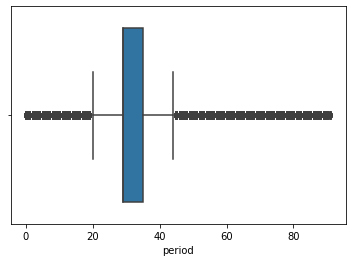

In [70]:
sns.boxplot(df_kick_ed['period'])
plt.show()

In [71]:
df_kick_ed.sort_values('period', ascending = False).head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_dt,launched_dt,period_dt,period
170950,1869674158,Cinema41,Film & Video,Film & Video,USD,2011-06-22,500.0,2011-03-22 23:58:12,500.0,1,17,US,500.0,500.0,500.0,2011-06-22,2011-03-22 23:58:12,91 days 00:01:48,91
206611,2052666527,Dark Timber Feature Film,Shorts,Film & Video,USD,2011-04-01,5000.0,2010-12-30 04:11:49,60.0,0,4,US,60.0,60.0,5000.0,2011-04-01,2010-12-30 04:11:49,91 days 19:48:11,91
243386,307797738,Angie McClure's new album,Indie Rock,Music,USD,2011-04-04,5000.0,2011-01-02 07:39:52,5275.0,1,63,US,5275.0,5275.0,5000.0,2011-04-04,2011-01-02 07:39:52,91 days 16:20:08,91
275427,471371117,The Secrets To Life,Rock,Music,USD,2011-04-01,3000.0,2010-12-30 10:01:11,470.0,0,25,US,470.0,470.0,3000.0,2011-04-01,2010-12-30 10:01:11,91 days 13:58:49,91
173919,1884484842,Uptown Praise Band 2nd Recording Project,Hip-Hop,Music,USD,2011-04-02,3800.0,2010-12-31 19:38:44,0.0,0,0,US,0.0,0.0,3800.0,2011-04-02,2010-12-31 19:38:44,91 days 04:21:16,91
88090,144788399,Traditions Build Winners as the Snipe Class tu...,Documentary,Film & Video,USD,2011-03-31,7500.0,2010-12-29 23:22:08,7625.0,1,56,US,7625.0,7625.0,7500.0,2011-03-31,2010-12-29 23:22:08,91 days 00:37:52,91
85716,1435845569,CanStar LLC Kickstarts Fundraising for 'Vincen...,Theater,Theater,USD,2011-04-02,7000.0,2010-12-31 18:12:36,7358.0,1,93,US,7358.0,7358.0,7000.0,2011-04-02,2010-12-31 18:12:36,91 days 05:47:24,91
74196,1378129953,SmoothnFusion Jazz Comedy Album,Jazz,Music,USD,2011-04-01,12500.0,2010-12-30 00:53:47,146.0,0,3,US,146.0,146.0,12500.0,2011-04-01,2010-12-30 00:53:47,91 days 23:06:13,91
135100,1685846406,Send Up For Nothing across the country!!,Pop,Music,USD,2011-04-01,10000.0,2010-12-30 05:00:03,2055.0,0,31,US,2055.0,2055.0,10000.0,2011-04-01,2010-12-30 05:00:03,91 days 18:59:57,91
22618,1114753005,Fair Trade Fashion by SET Boutique,Fashion,Fashion,USD,2011-04-04,7000.0,2011-01-02 20:21:23,817.0,0,20,US,817.0,817.0,7000.0,2011-04-04,2011-01-02 20:21:23,91 days 03:38:37,91


# データフレームを説明変数と目的変数のみにまとめる
統計情報と相関係数を確認する。

In [74]:
df_kick_mod = df_kick_ed[['period', 'usd_goal_real', 'state']]

display(df_kick_mod.head())
df_kick_mod.describe()

,period,usd_goal_real,state
0,58,1533.95,0
1,59,30000.00,0
2,44,45000.00,0
3,29,5000.00,0
5,34,50000.00,1


,period,usd_goal_real,state
count,331675.000000,3.316750e+05,331675.000000
mean,32.954902,4.151000e+04,0.403877
std,12.713329,1.108930e+06,0.490674
min,0.000000,1.000000e-02,0.000000
25%,29.000000,2.000000e+03,0.000000
50%,29.000000,5.000000e+03,0.000000
75%,35.000000,1.500000e+04,1.000000
max,91.000000,1.663614e+08,1.000000


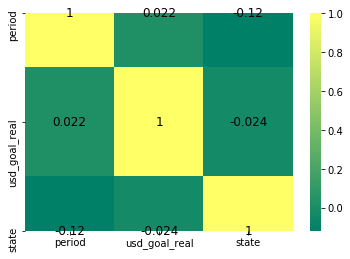

In [79]:
sns.heatmap(df_kick_mod.corr(), annot = True, cmap = 'summer', 
            annot_kws = {'size': 12, 'color': 'black'})

# ロジスティック回帰モデルを作成する

## 説明変数
* x1: period
* x2: usd_goal_real

## 目的変数
* y: state

In [81]:
X = df_kick_mod[['period', 'usd_goal_real']].values
y = df_kick_mod['state'].values

clf = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'none', random_state = 1234,
                   max_iter = 10000, tol = 1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

w0 = 7659.341, w1 = 182596.459, w2 = -200.988


In [87]:
# stateを予測
y_est = clf.predict(X)

accuracy = accuracy_score(y, y_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('正解率 = {:.3f}'.format(accuracy * 100))
print('適合率(precision) = {:.3f}'.format(precision[1] * 100))
print('再現率(recall) = {:.3f}'.format(recall[1] * 100))
print('F1値(F1-score) = {:.3f}'.format(f1_score[1] * 100))

正解率 = 48.525
適合率(precision) = 43.588
再現率(recall) = 93.313
F1値(F1-score) = 59.420


In [88]:
# 予測値と正解のクロス集計(混同行列)
conf_mat = confusion_matrix(y, y_est)
conf_mat = pd.DataFrame(conf_mat,
                       index = ['正解：失敗', '正解：成功'],
                       columns = ['予測：失敗', '予測：成功'])
conf_mat

,予測：失敗,予測：成功
正解：失敗,35946,161773
正解：成功,8957,124999


# 考察
precisionが低いため、正解率が低い。  
偽陰性が高いということは、成功と予測しても実際には失敗となる可能性が高く、事前の予測には不十分なモデルである。

usd_real_goalには異常に大きな値が多かったので、これらの値を何とかしないと正解率を上げることは難しい。